In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

In this notebook I perform Monte carlo simulations to predict future crypto prices.

In [2]:
#**IMPORTING DATA**
files=glob.glob('../../data/price_index_data/mod/*')

#getting the prices history from each index
data=[]
for file in files:
    data.append(pd.read_csv(file))

#converting the 'date' columns to datetime type
for i in data:
    i['date']=pd.to_datetime(i['date'])

#combining the data together
df=data[0]
for i in data[1:]:
    df=df.merge(i,on='date')

#removing the date column and setting it as the index
df.index=df['date']
df.drop(columns=['date'],inplace=True)

#removing unecessary columns
cols=[i for i in list(df.columns) if 'Unnamed' not in i]
df=df[cols]
df=df.dropna()

In [3]:
prices=df['bit_open']
change=((prices-prices.shift(1))/prices).dropna()

In [4]:
days=10
simulations=[]
rmses=[]
for runs in range(1,500):
    simulations=[]
    for run in range(runs):
        preds=[prices[0]]
        for day in range(days):
            preds.append(preds[-1]*(1+np.random.choice(change)))
        simulations.append(preds)
    simulations=pd.DataFrame(simulations)
    rmses.append([mse(list(prices[:11]), simulations.mean())**0.5,
                  mse(list(prices[:11]), simulations.quantile(.5))**0.5])

In [5]:
sim_mean=[i[0] for i in rmses]
sim_mid=[i[1] for i in rmses]

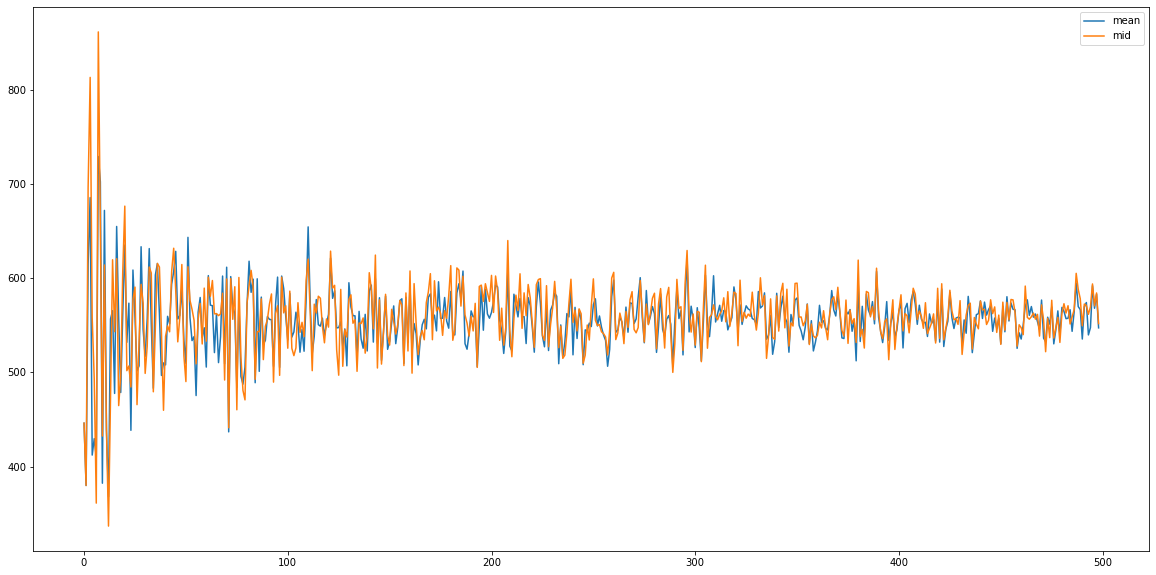

In [6]:
plt.figure(figsize=(20,10))
plt.plot(sim_mean,label='mean')
plt.plot(sim_mid,label='mid')
plt.legend()

After running 500 simulations, the average and the median of the simulations' mean squared error are close and stabilize over time so I will only look at the mean.

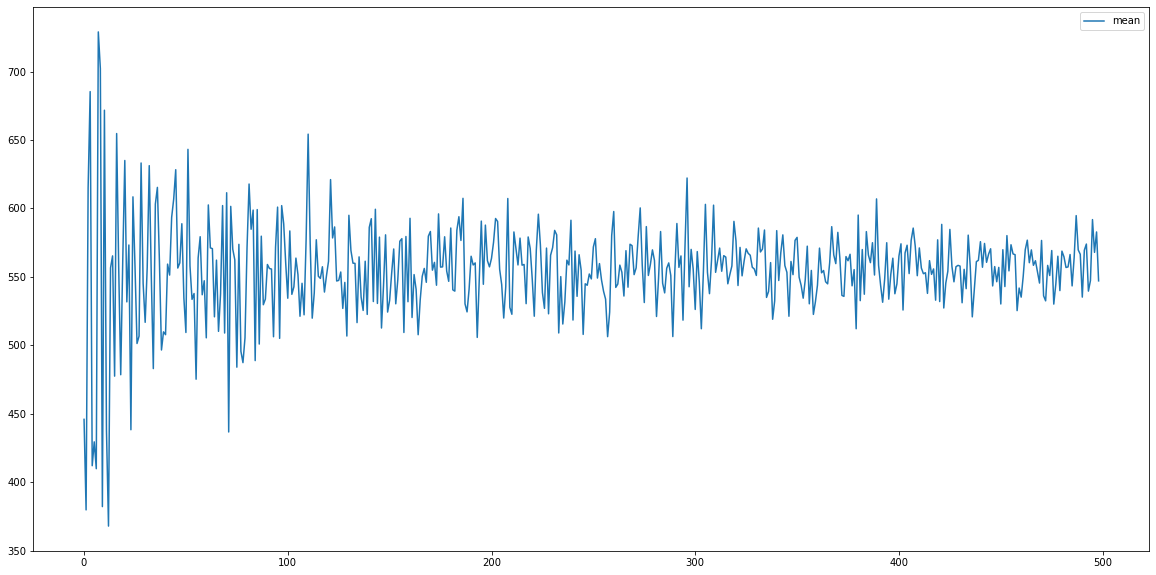

In [7]:
plt.figure(figsize=(20,10))
plt.plot(sim_mean,label='mean')
plt.legend()
original=sim_mean

In [8]:
print('Average Monte Carlo MSE:',pd.DataFrame(sim_mean).mean()[0])

Average Monte Carlo MSE: 554.885818666361


As noted in the data exploration stage, there are a lot of outliers in the target variable which makes prediction hard so I'll try to reduced the outliers to see if the simulations perform better.

In [9]:
prices=np.log(df['bit_open'])
change=((prices-prices.shift(1))/prices).dropna()
days=10
simulations=[]
rmses=[]
for runs in range(1,500):
    simulations=[]
    for run in range(runs):
        preds=[prices[0]]
        for day in range(days):
            preds.append(preds[-1]*(1+np.random.choice(change)))
        simulations.append(preds)
    simulations=pd.DataFrame(np.exp(simulations))
    temp=np.exp(list(prices[:11]))
    rmses.append([mse(temp, simulations.mean())**0.5,
                  mse(temp, (simulations.max()+simulations.min())/2)**0.5])

In [10]:
sim_mean=[i[0] for i in rmses]
sim_mid=[i[1] for i in rmses]

In [11]:
print('Average Monte Carlo MSE:',pd.DataFrame(sim_mean).mean()[0])

Average Monte Carlo MSE: 517.2251329442352


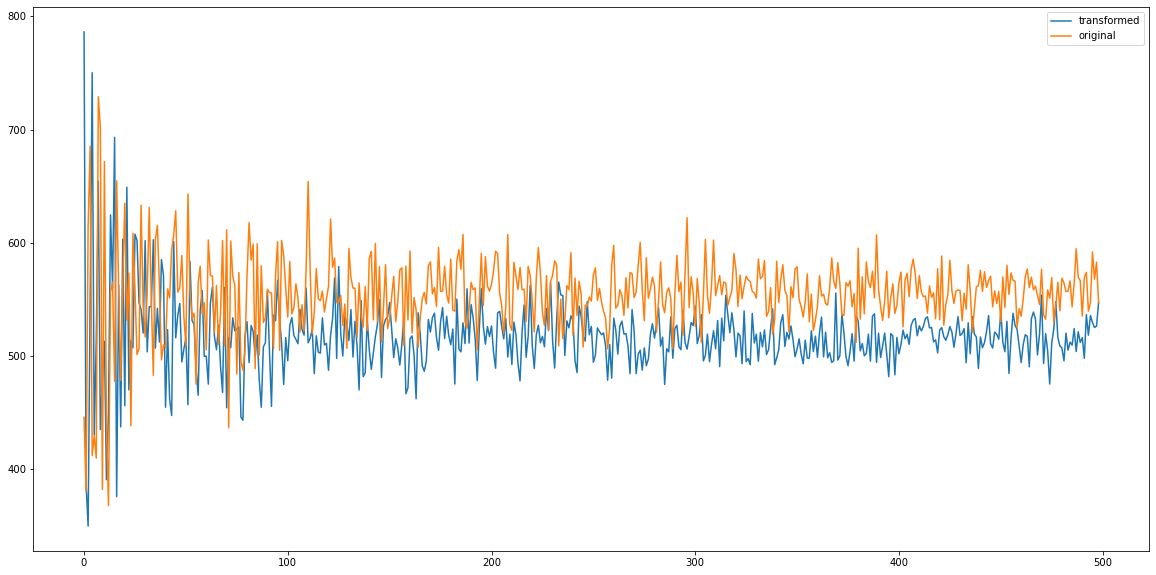

In [12]:
plt.figure(figsize=(20,10))
plt.plot(sim_mean,label='transformed')
plt.plot(original,label='original')
plt.legend()

The simulations perform slightly better with the transformed data so that is what I will use for this project.

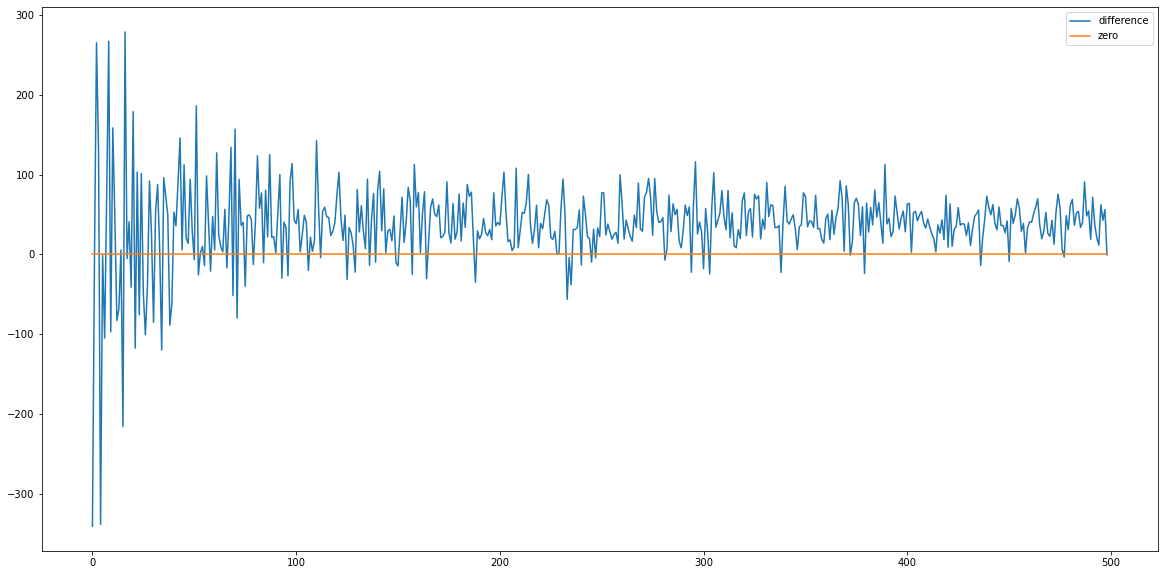

In [13]:
plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(original)-pd.DataFrame(sim_mean),label='difference')
plt.plot([0 for i in range(len(sim_mean))],label='zero')
plt.legend()

In [15]:
targets=['bit_close','eth_close','ada_close','bnb_close']
predictions=pd.DataFrame()
for target in targets: 
    prices=np.log(df[target])[:-10]
    change=((prices-prices.shift(1))/prices).dropna()
    days=10
    simulations=[]
    rmses=[]
    for run in range(100):
        preds=[prices[-1]]
        for day in range(days):
            preds.append(preds[-1]*(1+np.random.choice(change)))
        simulations.append(preds)
    simulations=pd.DataFrame(simulations)
    predictions[target]=np.exp(simulations.mean())

In [16]:
temp=[]
for i in predictions.columns:
    temp.append(i+'_monte_carlo')
predictions.columns=temp
predictions.index=df.index[-11:]

In [17]:
predictions.to_csv(f'../../data/predictions/monte_carlo.csv')

In [ ]:
aic= (temp[i]-temp[target])**2
aic/=temp.shape[0]
aic=np.log(aic)
aic*=temp.shape[0]
aic+=2*temp.shape[1]

In [23]:
y=df[targets][-10:]

In [24]:
y

,bit_close,eth_close,ada_close,bnb_close
date,,,,
2021-09-01,48487.011189,3771.524040,2.870767,490.068726
2021-09-02,49725.532134,3805.823968,2.963438,483.921051
2021-09-03,49709.611994,3879.477515,2.968239,488.604706
2021-09-07,46897.601477,3445.243837,2.502491,417.508789
2021-09-08,46769.314391,3559.717504,2.474989,415.113159
2021-09-09,46404.364481,3440.940392,2.517666,421.270020
2021-09-10,44720.755550,3205.832088,2.385911,401.621796
2021-09-13,45097.797218,3294.403758,2.400663,399.063446
2021-09-14,47039.949931,3391.221517,2.395638,414.236237


In [26]:
predictions=predictions[1:]

In [65]:
for target in targets:
    temp_y=y[target]
    y_hat=[i for i in predictions.columns if target in i]
    y_hat=predictions[y_hat]
    sse=0
    for i in range(len(temp_y)):
        sse+=(temp_y.values[i]-y_hat.values[i][0])**2
    aic=sse/10
    aic=10*np.log(aic)+2
    print(target,'AIC:',aic)

bit_close AIC: 160.00441873811684
eth_close AIC: 113.64738620092695
ada_close AIC: 171.41428077325438
bnb_close AIC: 77.30990454343456


Sources:
https://www.youtube.com/watch?v=_T0l015ecK4

In [67]:
(160.00441873811684+113.64738620092695+171.41428077325438+77.30990454343456)/4

130.5939975639332